#Data

In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from keras.utils import pad_sequences
from sklearn.metrics import *

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/data/Drug/drugsComTrain_raw.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/Drug/drugsComTest_raw.csv')

In [ ]:
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [ ]:
df_train.isna().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [ ]:
data = pd.concat([df_train,df_test]).reset_index()

In [ ]:
count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
target_conditions = count_df[count_df['review']>270]['condition'].values

def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"

data['condition'] = data['condition'].apply(lambda x: condition_parser(x))

<Axes: >

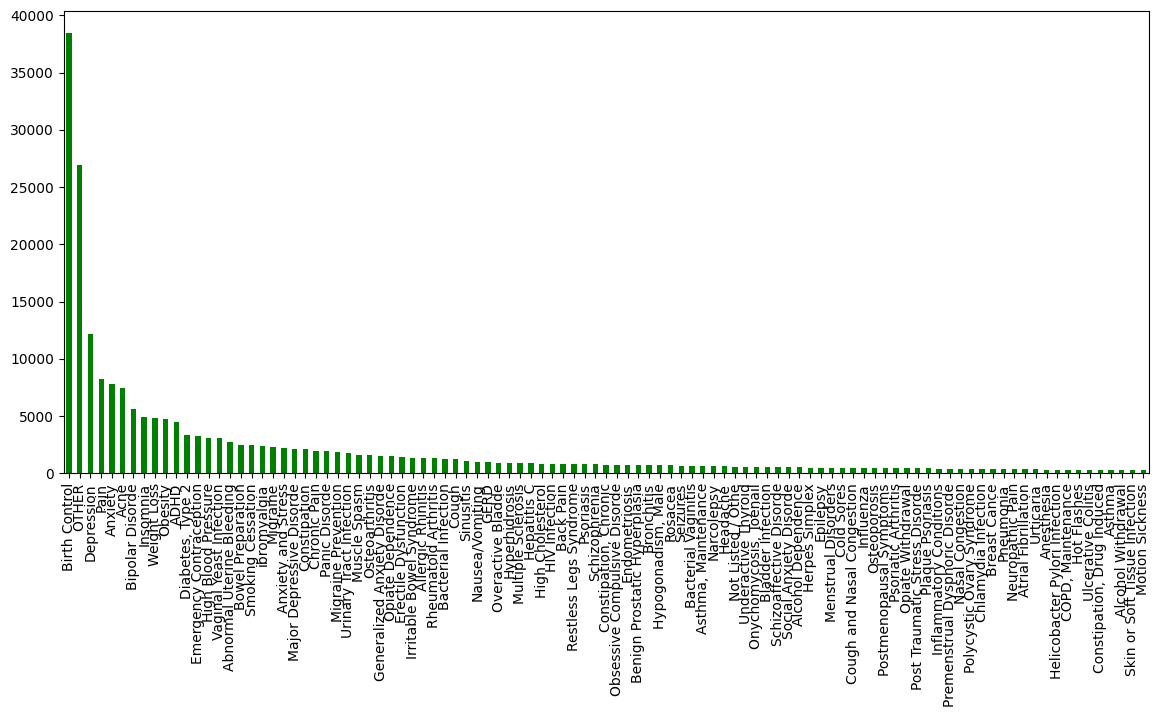

In [ ]:
condition = data.condition.value_counts().sort_values(ascending=False)
condition.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")

In [ ]:
stemmer = SnowballStemmer('english')
def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in words]
    # 7. space join words
    return( ' '.join(stemming_words))
data['review_clean'] = data['review'].apply(review_to_words)

<ipython-input-28-c5ff2721521b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [ ]:
data['sentiment'] = data["rating"].apply(lambda x: 1 if x > 5 else 0)

In [ ]:
import pickle

with open('/content/drive/MyDrive/data/Drug/Drug.pkl', 'rb') as fp:
  data = pickle.load(fp)
with open('/content/drive/MyDrive/data/Drug/train_X.pkl', 'rb') as fp:
  train_X = pickle.load(fp)
with open('/content/drive/MyDrive/data/Drug/test_X.pkl', 'rb') as fp:
  test_X = pickle.load(fp)
with open('/content/drive/MyDrive/data/Drug/val_X.pkl', 'rb') as fp:
  val_X = pickle.load(fp)

In [ ]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [ ]:
vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
pipeline = Pipeline([
    ('vect', vectorizer),
])
train_data_features = pipeline.fit_transform(df_train['review_clean'])
test_data_features = pipeline.transform(df_test['review_clean'])
val_data_features = pipeline.transform(df_val['review_clean'])

In [ ]:
maxlen = 750
train_X = pad_sequences(train_data_features.toarray(), maxlen=maxlen)
test_X = pad_sequences(test_data_features.toarray(), maxlen=maxlen)
val_X = pad_sequences(val_data_features.toarray(), maxlen=maxlen)

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/data/Drug/Drug.pkl', 'wb') as fp:
#     pickle.dump(data, fp)
# with open('/content/drive/MyDrive/data/Drug/train_X.pkl', 'wb') as fp:
#     pickle.dump(train_X, fp)
# with open('/content/drive/MyDrive/data/Drug/test_X.pkl', 'wb') as fp:
#     pickle.dump(test_X, fp)
# with open('/content/drive/MyDrive/data/Drug/val_X.pkl', 'wb') as fp:
#     pickle.dump(val_X, fp)

In [ ]:
y_train = df_train['sentiment']
y_test = df_test['sentiment']
y_val = df_val['sentiment']

In [ ]:
le = LabelEncoder()
df_train['condition_enc'] = le.fit_transform(df_train['condition'])
df_test['condition_enc'] = le.transform(df_test['condition'].values)
df_val['condition_enc'] = le.transform(df_val['condition'].values)

In [ ]:
train_label = df_train['condition_enc'].values
test_label = df_test['condition_enc'].values
val_label = df_val['condition_enc'].values

In [ ]:
# 2. Model Structure
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(200, input_shape=(750,)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(300))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               150200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               60300     
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                        

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
training = model.fit(train_X, y_train, batch_size=1024, epochs=5,
                     callbacks=[callback],
                    validation_data = (val_X, y_val))

Epoch 1/5
152/152 [==============================] - 10s 10ms/step - loss: 0.6172 - accuracy: 0.6982 - val_loss: 0.6252 - val_accuracy: 0.7022
Epoch 2/5
152/152 [==============================] - 1s 9ms/step - loss: 0.5962 - accuracy: 0.7084 - val_loss: 0.6152 - val_accuracy: 0.7113
Epoch 3/5
152/152 [==============================] - 1s 10ms/step - loss: 0.5894 - accuracy: 0.7111 - val_loss: 0.6035 - val_accuracy: 0.7149
Epoch 4/5
152/152 [==============================] - 1s 9ms/step - loss: 0.5857 - accuracy: 0.7129 - val_loss: 0.5933 - val_accuracy: 0.7150
Epoch 5/5
152/152 [==============================] - 2s 14ms/step - loss: 0.5844 - accuracy: 0.7129 - val_loss: 0.5903 - val_accuracy: 0.7147


In [ ]:
prediction = model.predict(test_X)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print(classification_report(y_test, pred_labels))

1345/1345 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.69      0.07      0.12     12940
           1       0.71      0.99      0.83     30073

    accuracy                           0.71     43013
   macro avg       0.70      0.53      0.47     43013
weighted avg       0.70      0.71      0.61     43013



In [ ]:
num_classes = 101
# 2. Model Structure
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Dense(200, input_shape=(750,)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Dense(300))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Dense(200, activation='relu'))
model2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# 3. Model compile
model2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
# model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               150200    
                                                                 
 batch_normalization_2 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 200)               0         
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 300)               60300     
                                                                 
 batch_normalization_3 (Batc  (None, 300)              1200      
 hNormalization)                                      

In [ ]:
y_train = tf.keras.utils.to_categorical(train_label, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(val_label, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(test_label, num_classes=num_classes)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
training = model2.fit(train_X, y_train, batch_size=1024, epochs=10,
                     callbacks=[callback],
                    validation_data = (val_X, y_val))

In [ ]:
prediction = model2.predict(test_X)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print(classification_report(y_test, pred_labels))

#Test Model

In [ ]:
def data_make(df_train, df_val, df_test):
  le = LabelEncoder()
  batch_size = 256
  train_Y = np.concatenate(df_train['sentiment'].values[:, np.newaxis])
  val_Y = np.concatenate(df_val['sentiment'].values[:, np.newaxis])
  test_Y = np.concatenate(df_test['sentiment'].values[:, np.newaxis])
  # num_classes = 2
  # train_Y = tf.keras.utils.to_categorical(train_Y, num_classes=num_classes)
  # val_Y = tf.keras.utils.to_categorical(val_Y, num_classes=num_classes)
  # test_Y = tf.keras.utils.to_categorical(test_Y, num_classes=num_classes)

  x_train = torch.from_numpy(train_X).float()
  y_train = torch.from_numpy(train_Y).float()
  x_val = torch.from_numpy(val_X).float()
  y_val = torch.from_numpy(val_Y).float()
  x_test = torch.from_numpy(test_X).float()
  y_test = torch.from_numpy(test_Y).float()

  # Create Torch datasets
  train = torch.utils.data.TensorDataset(x_train, y_train)
  valid = torch.utils.data.TensorDataset(x_val, y_val)
  test = torch.utils.data.TensorDataset(x_test, y_test)
  # Create Data Loaders
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
  return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = data_make(df_train, df_val, df_test)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # self.n_tasks = n_tasks
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(288, 2)
        setattr(self, 'task_{}'.format(0), nn.Linear(336, 1)) #2
        setattr(self, 'task_{}'.format(1), nn.Linear(336, 1)) #num_classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1,10,75)
        x = torch.unsqueeze(x, dim = 1)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0),-1)
        # print(x.shape)
        x = self.fc(x)
        # x = self.softmax(x)
        # outs = []
        # for i in range(self.n_tasks):
        #     layer = getattr(self, 'task_{}'.format(i))
        #     outs.append(layer(x))

        return x

In [ ]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
n_total_steps = len(train_loader)
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(1), labels.long())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Epoch [1/10], Step [100/605], Loss: 0.5895
Epoch [1/10], Step [200/605], Loss: 0.6126
Epoch [1/10], Step [300/605], Loss: 0.5544
Epoch [1/10], Step [400/605], Loss: 0.6255
Epoch [1/10], Step [500/605], Loss: 0.5894
Epoch [1/10], Step [600/605], Loss: 0.5598
Epoch [2/10], Step [100/605], Loss: 0.6298
Epoch [2/10], Step [200/605], Loss: 0.5919
Epoch [2/10], Step [300/605], Loss: 0.5707
Epoch [2/10], Step [400/605], Loss: 0.5919
Epoch [2/10], Step [500/605], Loss: 0.6015
Epoch [2/10], Step [600/605], Loss: 0.6113
Epoch [3/10], Step [100/605], Loss: 0.5850
Epoch [3/10], Step [200/605], Loss: 0.5991
Epoch [3/10], Step [300/605], Loss: 0.5937
Epoch [3/10], Step [400/605], Loss: 0.5763
Epoch [3/10], Step [500/605], Loss: 0.6295
Epoch [3/10], Step [600/605], Loss: 0.6016
Epoch [4/10], Step [100/605], Loss: 0.6052
Epoch [4/10], Step [200/605], Loss: 0.5786
Epoch [4/10], Step [300/605], Loss: 0.5881
Epoch [4/10], Step [400/605], Loss: 0.5423
Epoch [4/10], Step [500/605], Loss: 0.5891
Epoch [4/10

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)

        n_samples += labels.size(0)
        _, label = torch.max(labels, 1)
        n_correct += (predicted == label).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 69.916071885244 %


In [ ]:
vocab_size = 20000
embedding_dim = 200
hidden_dim = 256
output_dim = 2

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # self.n_tasks = n_tasks
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x.long())
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        out = self.softmax(out)
        return out

In [ ]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
n_total_steps = len(train_loader)
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

#Model

In [ ]:
def data_make(df_train, df_val, df_test):
  le = LabelEncoder()
  batch_size = 256
  num_classes = 101

  train_label2 = le.fit_transform(df_train['condition'].values)[:, np.newaxis]
  # train_label2 = tf.keras.utils.to_categorical(train_label2, num_classes=num_classes)
  val_label2 = le.transform(df_val['condition'].values)[:, np.newaxis]
  # val_label2 = tf.keras.utils.to_categorical(val_label2, num_classes=num_classes)
  test_label2 = le.transform(df_test['condition'].values)[:, np.newaxis]
  #test_label2 = tf.keras.utils.to_categorical(test_label2, num_classes=num_classes)


  # train_label1 = tf.keras.utils.to_categorical(df_train['sentiment'].values[:, np.newaxis], num_classes=2)
  # val_label1 = tf.keras.utils.to_categorical(df_val['sentiment'].values[:, np.newaxis], num_classes=2)
  # test_label1 = tf.keras.utils.to_categorical(df_test['sentiment'].values[:, np.newaxis], num_classes=2)

  train_label1 = df_train['sentiment'].values[:, np.newaxis]
  val_label1 = df_val['sentiment'].values[:, np.newaxis]
  test_label1 = df_test['sentiment'].values[:, np.newaxis]

  train_Y = np.concatenate((train_label1, train_label2), axis=1)
  val_Y = np.concatenate((val_label1, val_label2), axis=1)
  test_Y = np.concatenate((test_label1, test_label2), axis=1)

  x_train = torch.from_numpy(train_X).float()
  y_train = torch.from_numpy(train_Y).float()
  x_val = torch.from_numpy(val_X).float()
  y_val = torch.from_numpy(val_Y).float()
  x_test = torch.from_numpy(test_X).float()
  y_test = torch.from_numpy(test_Y).float()

  # Create Torch datasets
  train = torch.utils.data.TensorDataset(x_train, y_train)
  valid = torch.utils.data.TensorDataset(x_val, y_val)
  test = torch.utils.data.TensorDataset(x_test, y_test)
  # Create Data Loaders
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
  return train_loader, valid_loader, test_loader

In [ ]:
num_classes = 101

In [ ]:
# lenet base model for Pareto MTL
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.modules.loss import CrossEntropyLoss


class RegressionTrain(torch.nn.Module):

    def __init__(self, model,init_weight):
        super(RegressionTrain, self).__init__()

        self.model = model
        self.weights = torch.nn.Parameter(torch.from_numpy(init_weight).float())
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, x, ts):
        n_tasks = 2
        logit = self.model(x)
        task_loss = []

        task_loss.append(self.ce_loss(logit[0].squeeze(1), ts[:, 0].long()))
        task_loss.append(self.ce_loss(logit[1].squeeze(1), ts[:, 1].long()))

        task_loss = torch.stack(task_loss)

        return task_loss


class RegressionModel(torch.nn.Module):
    def __init__(self, n_tasks):
        super(RegressionModel, self).__init__()
        self.n_tasks = n_tasks
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)

        setattr(self, 'task_{}'.format(0), nn.Linear(336, 2)) #2
        setattr(self, 'task_{}'.format(1), nn.Linear(336, num_classes)) #num_classes


    def forward(self, x):
        x = x.view(-1,30,25)
        x = torch.unsqueeze(x, dim = 1)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0),-1)

        outs = []
        for i in range(self.n_tasks):
            layer = getattr(self, 'task_{}'.format(i))
            outs.append(layer(x))

        return outs

#Paper_anh_Tuan

In [ ]:
"""This code is referenced from kaggle
https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch """


import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re

maxlen = 750 # max number of words in a question to use
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
batch_size = 512 # how many samples to process at once

def load_glove(word_index, path):
    EMBEDDING_FILE = path + '/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

def dataset(path):
    data1 = pd.read_csv(path+"drugsComTrain_raw.csv")

    data2 = pd.read_csv(path+"drugsComTest_raw.csv")

    data = pd.concat([data1,data2])[['review', 'condition', 'rating']]

    # remove NULL Values from data
    data = data[pd.notnull(data['review'])]

    data['len'] = data['review'].apply(lambda s : len(s))
    count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
    target_conditions = count_df[count_df['review']>270]['condition'].values

    def condition_parser(x):
        if x in target_conditions:
            return x
        else:
            return "OTHER"

    data['condition'] = data['condition'].apply(lambda x: condition_parser(x))
    data = data[data['condition']!='OTHER']



    def clean_text(x):
        pattern = r'[^a-zA-z0-9\s]'
        text = re.sub(pattern, '', x)
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x


    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re
    contractions, contractions_re = _get_contractions(contraction_dict)
    def replace_contractions(text):
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)


    data["review"] = data["review"].apply(lambda x: x.lower())

    # Clean the text
    data["review"] = data["review"].apply(lambda x: clean_text(x))

    # Clean numbers
    data["review"] = data["review"].apply(lambda x: clean_numbers(x))

    # Clean Contractions
    data["review"] = data["review"].apply(lambda x: replace_contractions(x))


    data['rating'] /= 2 #convert range of rating to [0, 5]


    from sklearn.model_selection import train_test_split
    train_X, test_X, train_Y, test_Y = train_test_split(data['review'], data[['rating', 'condition']],
                                                        test_size=0.25)
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,
                                                        test_size=0.15)

    le = LabelEncoder()
    train_Y = np.concatenate((train_Y['rating'].values[:, np.newaxis], le.fit_transform(train_Y['condition'].values)[:, np.newaxis]), axis=1)
    val_Y = np.concatenate((val_Y['rating'].values[:, np.newaxis], le.transform(val_Y['condition'])[:, np.newaxis]), axis=1)
    test_Y = np.concatenate((test_Y['rating'].values[:, np.newaxis], le.transform(test_Y['condition'].values)[:, np.newaxis]), axis=1)

    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)


    x_train = torch.from_numpy(train_X).long()
    y_train = torch.from_numpy(train_Y).float()
    x_val = torch.from_numpy(val_X).long()
    y_val = torch.from_numpy(val_Y).float()
    x_test = torch.from_numpy(test_X).long()
    y_test = torch.from_numpy(test_Y).float()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_val, y_val)
    test = torch.utils.data.TensorDataset(x_test, y_test)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

    embedding_matrix = load_glove(tokenizer.word_index, path)
    return train_loader, valid_loader, test_loader, embedding_matrix

In [ ]:
class CNN_Target(nn.Module):

    def __init__(self, embed_size=300, num_filters=36):
        super(CNN_Target, self).__init__()
        self.filter_sizes = [1,2,3,5]
        self.num_filters = num_filters
        self.embed_size = embed_size
        self.n_classes = 100
        #n_classes = len(le.classes_)
        #self.embedding = nn.Embedding(max_features, embed_size)
        #self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        #self.embedding.weight.requires_grad = False
        #self.convs1 = nn.ModuleList([F.conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        #self.fc1 = nn.Linear(len(filter_sizes)*num_filters, 1)


    def forward(self, x, weights, embedding_matrix):
        x = F.embedding(x, embedding_matrix)
        x = x.unsqueeze(1)
        x_lst = []
        for i in range(len(self.filter_sizes)):
          x_lst.append(F.relu(F.conv2d(x, weight=weights[f'conv{i}.weights'].reshape(self.num_filters, 1, self.filter_sizes[i], self.embed_size),
                              bias=weights[f'conv{i}.bias'])).squeeze(3))
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x_lst]
        x = torch.cat(x, 1)
        #x = self.dropout(x)
        logit_MSE = F.linear(x, weight=weights[f'MSE.weights'].reshape(1, len(self.filter_sizes)*self.num_filters),
                         bias=weights[f'MSE.bias'])
        logit_CE = F.linear(x, weight=weights[f'CE.weights'].reshape(self.n_classes, len(self.filter_sizes)*self.num_filters),
                         bias=weights[f'CE.bias'])
        logits = [logit_MSE, logit_CE]
        return logits

#Training

In [ ]:
# This code is from
# Multi-Task Learning as Multi-Objective Optimization
# Ozan Sener, Vladlen Koltun
# Neural Information Processing Systems (NeurIPS) 2018
# https://github.com/intel-isl/MultiObjectiveOptimization

import numpy as np
import torch


class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-5

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This is correct only in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,j)] += torch.dot(vecs[i][k], vecs[j][k]).item()#torch.dot(vecs[i][k], vecs[j][k]).data[0]
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,i)] += torch.dot(vecs[i][k], vecs[i][k]).item()#torch.dot(vecs[i][k], vecs[i][k]).data[0]
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(j, j)] += torch.dot(vecs[j][k], vecs[j][k]).item()#torch.dot(vecs[j][k], vecs[j][k]).data[0]
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))

    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])

        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]


        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec

    def find_min_norm_element_FW(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the Frank Wolfe until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            t_iter = np.argmin(np.dot(grad_mat, sol_vec))

            v1v1 = np.dot(sol_vec, np.dot(grad_mat, sol_vec))
            v1v2 = np.dot(sol_vec, grad_mat[:, t_iter])
            v2v2 = grad_mat[t_iter, t_iter]

            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec
            new_sol_vec[t_iter] += 1 - nc

            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec


def gradient_normalizers(grads, losses, normalization_type):
    gn = {}
    if normalization_type == 'l2':
        for t in grads:
            gn[t] = np.sqrt(np.sum([gr.pow(2).sum().data[0] for gr in grads[t]]))
    elif normalization_type == 'loss':
        for t in grads:
            gn[t] = losses[t]
    elif normalization_type == 'loss+':
        for t in grads:
            gn[t] = losses[t] * np.sqrt(np.sum([gr.pow(2).sum().data[0] for gr in grads[t]]))
    elif normalization_type == 'none':
        for t in grads:
            gn[t] = 1.0
    else:
        print('ERROR: Invalid Normalization Type')
    return gn

In [ ]:
def get_d_paretomtl_init(grads,value,weights,i):
    """
    calculate the gradient direction for ParetoMTL initialization
    """

    flag = False
    nobj = value.shape

    # check active constraints
    current_weight = weights[i]
    rest_weights = weights
    w = rest_weights - current_weight

    gx =  torch.matmul(w,value/torch.norm(value))
    idx = gx >  0

    # calculate the descent direction
    if torch.sum(idx) <= 0:
        flag = True
        return flag, torch.zeros(nobj)
    if torch.sum(idx) == 1:
        sol = torch.ones(1).cuda().float()
    else:
        vec =  torch.matmul(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element([[vec[t]] for t in range(len(vec))])


    weight0 =  torch.sum(torch.stack([sol[j] * w[idx][j ,0] for j in torch.arange(0, torch.sum(idx))]))
    weight1 =  torch.sum(torch.stack([sol[j] * w[idx][j ,1] for j in torch.arange(0, torch.sum(idx))]))
    weight = torch.stack([weight0,weight1])


    return flag, weight


def get_d_paretomtl(grads,value,weights,i):
    """ calculate the gradient direction for ParetoMTL """

    # check active constraints
    current_weight = weights[i]
    rest_weights = weights
    w = rest_weights - current_weight

    gx =  torch.matmul(w,value/torch.norm(value))
    idx = gx >  0


    # calculate the descent direction
    if torch.sum(idx) <= 0:
        sol, nd = MinNormSolver.find_min_norm_element([[grads[t]] for t in range(len(grads))])
        return torch.tensor(sol).cuda().float()


    vec =  torch.cat((grads, torch.matmul(w[idx],grads)))
    sol, nd = MinNormSolver.find_min_norm_element([[vec[t]] for t in range(len(vec))])


    weight0 =  sol[0] + torch.sum(torch.stack([sol[j] * w[idx][j - 2 ,0] for j in torch.arange(2, 2 + torch.sum(idx))]))
    weight1 =  sol[1] + torch.sum(torch.stack([sol[j] * w[idx][j - 2 ,1] for j in torch.arange(2, 2 + torch.sum(idx))]))
    weight = torch.stack([weight0,weight1])

    return weight


def circle_points(r, n):
    """
    generate evenly distributed unit preference vectors for two tasks
    """
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

In [ ]:
def train(base_model, niter, npref, init_weight, pref_idx):

    # generate #npref preference vectors
    n_tasks = 2
    ref_vec = torch.tensor(circle_points([1], [npref])[0]).cuda().float()

    # load dataset
    train_loader, val_loader, test_loader = data_make(df_train, df_val, df_test)

    print('==>>> total trainning batch number: {}'.format(len(train_loader)))
    print('==>>> total testing batch number: {}'.format(len(test_loader)))


    # define the base model for ParetoMTL
    if base_model == 'lenet':
        model = RegressionTrain(RegressionModel(n_tasks), init_weight)
    if base_model == 'resnet18':
        model = RegressionTrainResNet(MnistResNet(n_tasks), init_weight)


    if torch.cuda.is_available():
        model.cuda()


    # choose different optimizer for different base model
    if base_model == 'lenet':
        optimizer = torch.optim.SGD(model.parameters(), lr=5*1e-3, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,30,45,60,75,90], gamma=0.5)

    if base_model == 'resnet18':
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)


    # store infomation during optimization
    weights = []
    task_train_losses = []
    train_accs = []
    task_test_losses = []
    test_accs = []
    learning_rate = []

    # print the current preference vector
    print('Preference Vector ({}/{}):'.format(pref_idx + 1, npref))
    print(ref_vec[pref_idx].cpu().numpy())

    # run at most 2 epochs to find the initial solution
    # stop early once a feasible solution is found
    # usually can be found with a few steps
    for t in range(2):

        model.train()
        for (it, batch) in enumerate(train_loader):
            X = batch[0]
            ts = batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                ts = ts.cuda()

            grads = {}
            losses_vec = []


            # obtain and store the gradient value
            for i in range(n_tasks):
                optimizer.zero_grad()
                task_loss = model(X, ts)
                losses_vec.append(task_loss[i].data)

                task_loss[i].backward()

                grads[i] = []

                # can use scalable method proposed in the MOO-MTL paper for large scale problem
                # but we keep use the gradient of all parameters in this experiment
                for param in model.parameters():
                    if param.grad is not None:
                        grads[i].append(Variable(param.grad.data.clone().flatten(), requires_grad=False))



            grads_list = [torch.cat(grads[i]) for i in range(len(grads))]
            grads = torch.stack(grads_list)

            # calculate the weights
            losses_vec = torch.stack(losses_vec)
            flag, weight_vec = get_d_paretomtl_init(grads,losses_vec,ref_vec,pref_idx)

            # early stop once a feasible solution is obtained
            if flag == True:
                print("fealsible solution is obtained.")
                break

            # optimization step
            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss = model(X, ts)
                if i == 0:
                    loss_total = weight_vec[i] * task_loss[i]
                else:
                    loss_total = loss_total + weight_vec[i] * task_loss[i]

            loss_total.backward()
            optimizer.step()

        else:
        # continue if no feasible solution is found
            continue
        # break the loop once a feasible solutions is found
        break



    # run niter epochs of ParetoMTL
    for t in range(niter):

        scheduler.step()

        model.train()
        for (it, batch) in enumerate(train_loader):

            X = batch[0]
            ts = batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                ts = ts.cuda()

            # obtain and store the gradient
            grads = {}
            losses_vec = []

            for i in range(n_tasks):
                optimizer.zero_grad()
                task_loss = model(X, ts)
                losses_vec.append(task_loss[i].data)

                task_loss[i].backward()

                # can use scalable method proposed in the MOO-MTL paper for large scale problem
                # but we keep use the gradient of all parameters in this experiment
                grads[i] = []
                for param in model.parameters():
                    if param.grad is not None:
                        grads[i].append(Variable(param.grad.data.clone().flatten(), requires_grad=False))



            grads_list = [torch.cat(grads[i]) for i in range(len(grads))]
            grads = torch.stack(grads_list)

            # calculate the weights
            losses_vec = torch.stack(losses_vec)
            weight_vec = get_d_paretomtl(grads,losses_vec,ref_vec,pref_idx)

            normalize_coeff = n_tasks / torch.sum(torch.abs(weight_vec))
            weight_vec = weight_vec * normalize_coeff

            # optimization step
            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss = model(X, ts)
                if i == 0:
                    loss_total = weight_vec[i] * task_loss[i]
                else:
                    loss_total = loss_total + weight_vec[i] * task_loss[i]

            loss_total.backward()
            optimizer.step()


        # calculate and record performance
        if t == 0 or (t + 1) % 2 == 0:

            model.eval()
            with torch.no_grad():

                total_train_loss = []
                train_acc = []

                correct1_train = 0
                correct2_train = 0

                for (it, batch) in enumerate(train_loader):

                    X = batch[0]
                    ts = batch[1]
                    if torch.cuda.is_available():
                        X = X.cuda()
                        ts = ts.cuda()

                    valid_train_loss = model(X, ts)
                    total_train_loss.append(valid_train_loss)
                #     output1 = model.model(X).max(2, keepdim=True)[1][:,0]
                #     output2 = model.model(X).max(2, keepdim=True)[1][:,1]
                #     correct1_train += output1.eq(ts[:,0].view_as(output1)).sum().item()
                #     correct2_train += output2.eq(ts[:,1].view_as(output2)).sum().item()


                # train_acc = np.stack([1.0 * correct1_train / len(train_loader.dataset),1.0 * correct2_train / len(train_loader.dataset)])

                total_train_loss = torch.stack(total_train_loss)
                average_train_loss = torch.mean(total_train_loss, dim = 0)

                total_test_loss = []
                test_acc = []

                correct1_test = 0
                correct2_test = 0

                for (it, batch) in enumerate(test_loader):

                    X = batch[0]
                    ts = batch[1]
                    if torch.cuda.is_available():
                        X = X.cuda()
                        ts = ts.cuda()

                    valid_test_loss = model(X, ts)
                    total_test_loss.append(valid_test_loss)
                #     output1 = model.model(X).max(2, keepdim=True)[1][:,0]
                #     output2 = model.model(X).max(2, keepdim=True)[1][:,1]
                #     correct1_test += output1.eq(ts[:,0].view_as(output1)).sum().item()
                #     correct2_test += output2.eq(ts[:,1].view_as(output2)).sum().item()


                # test_acc = np.stack([1.0 * correct1_test / len(test_loader.dataset),1.0 * correct2_test / len(test_loader.dataset)])

                total_test_loss = torch.stack(total_test_loss)
                average_test_loss = torch.mean(total_test_loss, dim = 0)
            # # record and print
            if torch.cuda.is_available():

                task_train_losses.append(average_train_loss.data.cpu().numpy())
                #train_accs.append(train_acc)

                task_test_losses.append(average_test_loss.data.cpu().numpy())
                #test_accs.append(test_acc)
                weights.append(weight_vec.cpu().numpy())

            #     print('{}/{}: weights={}, train_loss={}, train_acc={}, test_loss={}, test_acc={}'.format(
            #             t + 1, niter,  weights[-1], task_train_losses[-1],train_accs[-1], task_test_losses[-1], test_accs[-1]))
            print('{}/{}: weights={}, train_loss={}, test_loss={}'.format(
                    t + 1, niter,  weights[-1], task_train_losses[-1], task_test_losses[-1]))

    torch.save(model.model.state_dict(), '/content/drive/MyDrive/save_model/%s_%s_niter_%d_npref_%d_prefidx_%d.pickle'%(dataset, base_model, niter, npref, pref_idx))

    return task_train_losses, train_accs, task_test_losses, test_accs

In [ ]:
def run(dataset = 'fashion_and_mnist', base_model = 'resnet18', niter = 100, npref = 20):
    """
    run Pareto MTL
    """

    init_weight = np.array([0.5 , 0.5 ])
    task_train_losses_pref = []
    train_accs_pref = []
    task_test_losses_pref = []
    test_accs_pref = []
    learning_rate_pref = []

    for i in range(npref):

        pref_idx = i
        task_train_losses, train_accs, task_test_losses, test_accs, learning_rate = train(base_model, niter, npref, init_weight, pref_idx)
        task_train_losses_pref.append(task_train_losses)
        train_accs_pref.append(train_accs)
        task_test_losses_pref.append(task_test_losses)
        test_accs_pref.append(test_accs)
        learning_rate_pref.append(learning_rate)
    return  task_train_losses_pref, train_accs_pref, task_test_losses_pref, test_accs_pref, learning_rate_pref

In [ ]:
task_train_losses_pref, train_accs_pref, task_test_losses_pref, test_accs_pref, learning_rate_pref = run(dataset = 'mnist', base_model = 'lenet', niter = 100, npref = 5)

==>>> total trainning batch number: 605
==>>> total testing batch number: 169
Preference Vector (1/5):
[1. 0.]
fealsible solution is obtained.
1/100: weights=[0.00805293 1.9919469 ], train_loss=[8.663476  3.6542287], test_loss=[8.642089 3.647726]
2/100: weights=[0.01641155 1.9835885 ], train_loss=[5.306173 3.651757], test_loss=[5.2929463 3.6461565]
4/100: weights=[1.2474892 0.7525107], train_loss=[0.6090197 3.648554 ], test_loss=[0.61045974 3.6421866 ]
6/100: weights=[0.87809384 1.1219063 ], train_loss=[0.6063093 3.6474657], test_loss=[0.608212  3.6421466]
8/100: weights=[1.7758887  0.22411136], train_loss=[0.6041202 3.6512485], test_loss=[0.60628915 3.6458902 ]
10/100: weights=[1.9289275  0.07107249], train_loss=[0.60308367 3.6421576 ], test_loss=[0.605622  3.6371129]
12/100: weights=[1.7708126 0.2291874], train_loss=[0.60166407 3.6399648 ], test_loss=[0.6043719 3.6351023]
14/100: weights=[0.5374695 1.4625305], train_loss=[0.60243607 3.6374664 ], test_loss=[0.6053768 3.633347 ]
16/100